In [283]:
##################UCITAVANJE NEOPHODNIH BIBLIOTEKA###########
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
import random as rd
import math 
from bokeh.plotting import figure
from sklearn.decomposition import PCA
from sklearn.decomposition import PCA
import matplotlib
%matplotlib inline

In [284]:
###################INICIJALIZACIJA CENTARA#####################
def center_initialization(data, num_of_clusters):

    columns = []
    for col in data.columns:
        columns.append(data[col].values)

    ##trazimo minimum i maksimum u svakoj koloni da bismo znali u kom opsegu mozemo da generisemo
    ##pocetne centre
    column_max_array = []
    column_min_array = []

    for i in columns:
        #kastovanje iz numpy float64 tipa u python float tip
        max_in_column = float(i.max())
        min_in_column = float(i.min())
        column_max_array.append(max_in_column)
        column_min_array.append(min_in_column)

    #random biranje pocetnih centara, tako da koordinate budu u opsegu minimalne i 
    #maksimalne vrednosti za taj atribut
    center_array = []

    for i in range(0, num_of_clusters):
        center = []
        for k in range (0, len(column_max_array)):
            min_value = int(column_min_array[k])
            max_value = int(column_max_array[k])
            random_coordinate = rd.randint(min_value, max_value)
            center.append(random_coordinate)
        center_array.append(center)

    return center_array

In [285]:
##################GLAVNI DEO, EXPECTATION MAXIMIZATION ALGORITAM#################

def EM_procedure(num_of_clusters, data, beta, num_iterations, center_array):
    
    #inicijalizacija tzv "skrivene" matrice 
    hidden_matrix = np.zeros([num_of_clusters,num_data])

    for param in range(0, 20):

        data_points_array = []

        #########################KORAK od centara do klastera#############################
        for index, row in data.iterrows():

            print ('Iteracija ' + str(index))
            #racunamo za svaku tacku rastojanje do svih centara
            point = data.ix[index].values

            #ispisi su za debagovanje
            print ('Tacka: ' + str(point))

            point_center_distance_array = []
            data_points_array.append(point)

            for center in center_array:
                #prvo racunamo obicno rastojanje izmedju centra i tacke
                distance = 0
                for p in range(0, len(point)):
                    distance = distance + (point[p]-center[p])*(point[p]-center[p])

                print ('Centar ' + str(center) + ' rastojanje ' + str(p) + ' ' + str(point) + '=' + str(distance))

                #a zatim racunamo vrednost partition funkcije po kojoj formiramo skrivenu matricu
                partition_function = math.exp(math.sqrt(distance) * (-beta)) 

                print ('Centar ' + str(center) + ' novo rastojanje ' + str(p) + ' ' + str(point) + '=' + str(partition_function))

                point_center_distance_array.append(partition_function) 

            sum_point_center_distance = sum(point_center_distance_array)

            print ('Partition function' + str(point_center_distance_array))
            print ('Sume rastojanja centara od tacke ' + str(sum_point_center_distance))

            for num_centers in range(0, num_of_clusters):
                hidden_matrix[num_centers,index] = point_center_distance_array[num_centers]/sum_point_center_distance
            print ('Hidden matrix: ' + str(hidden_matrix))


        ####################KORAK od klastera do novih centara########################

        center_array = []
        new_coordinate_of_center_i = 0

        print ('Tacke: ' + str(data_points_array))
        for i in range (0, num_of_clusters):
            new_center = []

            sum_of_i_row = sum(hidden_matrix[i])

            #racunanje novih koordinata centara na osnovu skrivene matrice
            for num_coord in range(0, num_attributes):
                new_coordinate_of_center_i = 0
                for dp in range(0, len(data_points_array)):
                    print (str(hidden_matrix[i, dp]) + ' ' + str(data_points_array[dp][num_coord]))
                    new_coordinate_of_center_i += (hidden_matrix[i, dp] * data_points_array[dp][num_coord])

                new_coordinate_of_center_i = new_coordinate_of_center_i/sum_of_i_row
                new_center.append(new_coordinate_of_center_i)   

            center_array.append(new_center)

        print ('Novi centri' + str(center_array))
        

    return center_array, hidden_matrix, data_points_array

In [286]:
#####################DODELJIVANJE TACAKA KLASTERIMA###################

def cluster_creating(cols, data_points_array,hidden_matrix):

    #inicijalizacija klastera
    data_cluster = {}

    for i in range (0, len(hidden_matrix[0])):
        hidden_matrix_column = hidden_matrix[:,i]
        max_hidden_matrix_column = hidden_matrix_column.argmax()
        key = max_hidden_matrix_column
        if key in data_cluster.keys():
            data_cluster[key].append(data_points_array[i])
        else:
            data_cluster[key] = []
            data_cluster[key].append(data_points_array[i])
    
    dataframe = pd.DataFrame(list(data_cluster.items()), columns=['Center','Points'])
    
    ################FORMIRANJE NOVOG DATAFRAME-a SA INFORMACIJOM O KLASTERU

    new_dataframe = pd.DataFrame(columns=cols)

    index_data_points = -1

    for index, row in dataframe.iterrows():
        center = row.values[0]
        array_of_points = row.values[1]
        for i in array_of_points:
            index_data_points += 1
            for j in range (0, len(i)):
                point = []
                new_dataframe.set_value(index_data_points, cols[j], i[j])
                new_dataframe.set_value(index_data_points, 'cluster', center)

    return new_dataframe


In [287]:
#################PRIKAZIVANJE REZULTATA####################
def visualize(num_of_clusters, new_dataframe, cluster_column):
    
    colors = matplotlib.cm.rainbow(np.linspace(0, 1, num_of_clusters))

    for index, row in new_dataframe.iterrows():
        point = new_dataframe.ix[index].values 
        col = point[cluster_column]
        point = point[:-1]
        if (len(point) > 2):
            plt.plot(point, color = colors[col])
        #else:
         #   name = 'cluster #' + str(int(col))
        #  plt.plot(point, 0, color = colors[col], marker='o', markersize=10. label = name)
    plt.show()
    
    
    plt.style.use('ggplot')

    fig, ax = plt.subplots(figsize=(10, 8))
    ax.set_prop_cycle(color=colors)
    ax.margins(0.05)

    p = figure(x_axis_label='Component A', y_axis_label='Component B')

    if (num_attributes>3):

        #redukcija dimenzionalnosti
        pca = PCA(n_components=2)
        pca.fit(new_dataframe[cols[:-1]].transpose())

        low_dimensional_frame = pd.DataFrame(pca.components_.T, columns=['component_a', 'component_b'])
        low_dimensional_frame['cluster'] = new_dataframe['cluster']

        for i in range(0,num_of_clusters):
            cluster_variable = low_dimensional_frame[low_dimensional_frame.cluster == i]
            p.circle(x=cluster_variable['component_a'], y=cluster_variable['component_b'], color=colors[i], size=10, alpha=0.8)

        groups = low_dimensional_frame.groupby('cluster')

        for name, group in groups:
            name = 'cluster #' + str(int(name)+1)
            ax.plot(group.component_a, group.component_b, marker='o', linestyle='', ms=12, label=name)
        ax.legend(numpoints=1, loc='upper left')

        plt.show()

    elif (num_attributes == 2):

        for i in range(0,num_of_clusters):
            cluster_variable = new_dataframe[new_dataframe.cluster == i]
            p.circle(x=cluster_variable[cols[0]], y=cluster_variable[cols[1]], color=colors[i], size=10, alpha=0.8)

        groups = new_dataframe.groupby('cluster')

        for name, group in groups:
            name = 'cluster #' + str(int(name)+1)
            ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, label=name)
        ax.legend(numpoints=1, loc='upper left')

        plt.show()
        

In [288]:
#######GENI KVASCA######

#ucitavamo .csv fajl sa genskim ekspresijama 
#(samo ih je 10, radi lakse ilustracije i brzeg rada programa)
#data = pd.read_csv('10_yeast_genes.csv', '\t')

data = pd.read_csv('10_yeast_genes.csv', '\t')

#brisemo nedostajuce vrednosti
data = data.dropna()

#za posebne fajlove, kada je prva kolona npr identifikator gena, 
#pa necemo da je uzimamo u obzir
#data = data[cols[1:]]
#data = data.reset_index(drop=True)

#odredjivanje dimenzija matrice, odnosno dataframe-a
shape = data.shape
num_attributes = shape[1]
num_data = shape[0]

#nazivi kolona i dodavanje nove kolone za klaster
cols = list(data)
cols.append('cluster')

#broj klasterovanja - PARAMETAR
num_of_clusters = 3

#beta - PARAMETAR
beta = 2

#broj iteracija - PARAMETAR
num_iterations = 100

center_array = center_initialization(data, num_of_clusters)
center_array, hidden_matrix, data_points_array = EM_procedure(num_of_clusters, data, beta, num_iterations, center_array)
new_dataframe = cluster_creating(cols, data_points_array, hidden_matrix)


Iteracija 0
Tacka: [ 0.14  0.03 -0.06  0.07 -0.01 -0.06 -0.01]
Centar [0, 0, 0, -1, 0, 0, -3] rastojanje 6 [ 0.14  0.03 -0.06  0.07 -0.01 -0.06 -0.01]=10.1128
Centar [0, 0, 0, -1, 0, 0, -3] novo rastojanje 6 [ 0.14  0.03 -0.06  0.07 -0.01 -0.06 -0.01]=0.0017291491972845437
Centar [0, 0, 0, 0, -1, 3, 0] rastojanje 6 [ 0.14  0.03 -0.06  0.07 -0.01 -0.06 -0.01]=10.3728
Centar [0, 0, 0, 0, -1, 3, 0] novo rastojanje 6 [ 0.14  0.03 -0.06  0.07 -0.01 -0.06 -0.01]=0.001594226976136381
Centar [0, 0, 0, 0, 0, 1, 0] rastojanje 6 [ 0.14  0.03 -0.06  0.07 -0.01 -0.06 -0.01]=1.1528
Centar [0, 0, 0, 0, 0, 1, 0] novo rastojanje 6 [ 0.14  0.03 -0.06  0.07 -0.01 -0.06 -0.01]=0.11679085766879597
Partition function[0.0017291491972845437, 0.001594226976136381, 0.11679085766879597]
Sume rastojanja centara od tacke 0.1201142338422169
Hidden matrix: [[ 0.01439587  0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.01327259  0.          0.          0.    

In [289]:
new_dataframe = cluster_creating(cols, data_points_array, hidden_matrix)

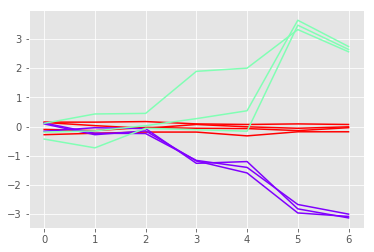

/Users/milicakojicic/anaconda/lib/python3.6/site-packages/bokeh/models/sources.py:81: BokehUserWarning: ColumnDataSource's columns must be of the same length
  lambda: warnings.warn("ColumnDataSource's columns must be of the same length", BokehUserWarning))
/Users/milicakojicic/anaconda/lib/python3.6/site-packages/bokeh/models/sources.py:81: BokehUserWarning: ColumnDataSource's columns must be of the same length
  lambda: warnings.warn("ColumnDataSource's columns must be of the same length", BokehUserWarning))
/Users/milicakojicic/anaconda/lib/python3.6/site-packages/bokeh/models/sources.py:81: BokehUserWarning: ColumnDataSource's columns must be of the same length
  lambda: warnings.warn("ColumnDataSource's columns must be of the same length", BokehUserWarning))
/Users/milicakojicic/anaconda/lib/python3.6/site-packages/bokeh/models/sources.py:81: BokehUserWarning: ColumnDataSource's columns must be of the same length
  lambda: warnings.warn("ColumnDataSource's columns must be of the s

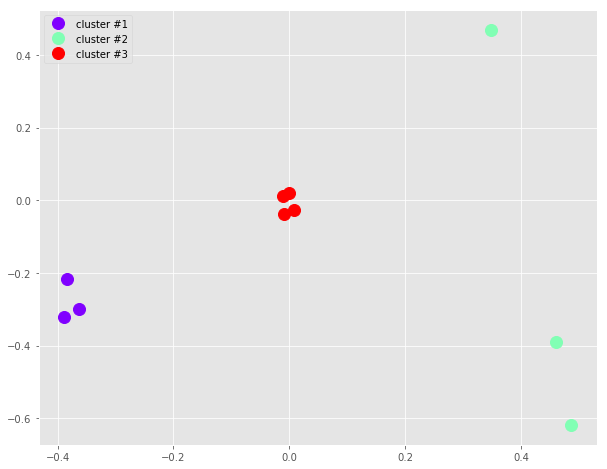

In [290]:
visualize(num_of_clusters, new_dataframe, 7)

########NECEMO DA NAM SE PRIKAZUJU CRVENI WARNING#########
from IPython.display import HTML
HTML('''<script>
code_show_err=false; 
function code_toggle_err() {
 if (code_show_err){
 $('div.output_stderr').hide();
 } else {
 $('div.output_stderr').show();
 }
 code_show_err = !code_show_err
} 
$( document ).ready(code_toggle_err);
</script>
To toggle on/off output_stderr, click <a href="javascript:code_toggle_err()">here</a>.''')

In [291]:
##################IZVOZ PODATAKA U .CSV FORMAT########

for i in reversed(range(0, num_of_clusters)):
    new_dataframe.loc[new_dataframe['cluster'] == i, 'cluster'] = i+1
new_dataframe.to_csv('yeast_gene_expression.csv', index = False)

new_dataframe

GSM887 GSM888 GSM889 GSM890 GSM891 GSM892 GSM893 cluster
0   0.14   0.03  -0.06   0.07  -0.01  -0.06  -0.01       3
1   -0.1  -0.14  -0.03  -0.06  -0.07  -0.14  -0.04       3
2  -0.28  -0.23  -0.19  -0.19  -0.32  -0.18  -0.18       3
3   0.15   0.15   0.17   0.09   0.07   0.09   0.07       3
4   0.12  -0.23  -0.24  -1.16   -1.4  -2.67     -3       1
5   0.09  -0.28  -0.15  -1.18  -1.59  -2.96  -3.08       1
6  -0.16  -0.04  -0.07  -1.26   -1.2  -2.82  -3.13       1
7  -0.43  -0.73  -0.06  -0.11  -0.16   3.47   2.64       2
8   0.11   0.43   0.45   1.89      2   3.32   2.56       2
9  -0.19  -0.15   0.03   0.27   0.54   3.64   2.74       2

In [292]:
#######TUMOR-NORMAL GENI - POTENCIJALNI BIOMARKERI######

#ucitavamo .csv fajl sa genskim ekspresijama 

#data = pd.read_csv('t_n_colon.csv/gene_biomarkers.csv', ',')

data = pd.read_csv('t_n_colon.csv/malo_gena.csv', ',')

#brisemo nedostajuce vrednosti
data = data.dropna()

#za posebne fajlove, kada je prva kolona npr identifikator gena, 
#pa necemo da je uzimamo u obzir
#data = data[cols[1:]]|
#data = data.reset_index(drop=True)


data_tumor = pd.DataFrame(data['Intensity in Tumor'])
data_tumor.columns = ['x']
data_tumor['y'] = 0 

data_normal = pd.DataFrame(data['Intensity in Normal'])
data_normal.columns = ['x']
data_normal['y'] = 0 

shape = data_tumor.shape
num_attributes = shape[1]
num_data = shape[0]

#nazivi kolona 
cols = list(data_tumor)
cols.append('cluster')

cols_normal = list(data_normal)
cols_normal.append('cluster')

#broj klasterovanja - PARAMETAR
num_of_clusters = 3

#beta  - PARAMETAR
beta = 2

#broj iteracija - PARAMETAR
num_iterations = 100
num_attributes


2

In [293]:
######TUMOR KLASTER#####
center_array_tumor = center_initialization(data_tumor, num_of_clusters)
center_array_tumor, hidden_matrix_tumor, data_points_array_tumor = EM_procedure(num_of_clusters, data_tumor, beta, num_iterations, center_array_tumor)
new_dataframe_tumor = cluster_creating(cols, data_points_array_tumor, hidden_matrix_tumor)

Iteracija 0
Tacka: [ 123.5    0. ]
Centar [148, 0] rastojanje 1 [ 123.5    0. ]=600.25
Centar [148, 0] novo rastojanje 1 [ 123.5    0. ]=5.242885663363464e-22
Centar [151, 0] rastojanje 1 [ 123.5    0. ]=756.25
Centar [151, 0] novo rastojanje 1 [ 123.5    0. ]=1.2995814250075031e-24
Centar [88, 0] rastojanje 1 [ 123.5    0. ]=1260.25
Centar [88, 0] novo rastojanje 1 [ 123.5    0. ]=1.462486227251231e-31
Partition function[5.242885663363464e-22, 1.2995814250075031e-24, 1.462486227251231e-31]
Sume rastojanja centara od tacke 5.255881479076025e-22
Hidden matrix: [[  9.97527377e-01   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000

In [295]:
######NORMAL KLASTER#####
center_array_normal = center_initialization(data_normal, num_of_clusters)
center_array_normal, hidden_matrix_normal, data_points_array_normal = EM_procedure(num_of_clusters, data_normal, beta, num_iterations, center_array_normal)
new_dataframe_normal = cluster_creating(cols_normal, data_points_array_normal, hidden_matrix_normal)

Iteracija 0
Tacka: [ 18.9   0. ]
Centar [876, 0] rastojanje 1 [ 18.9   0. ]=734620.41
Centar [876, 0] novo rastojanje 1 [ 18.9   0. ]=0.0
Centar [280, 0] rastojanje 1 [ 18.9   0. ]=68173.21
Centar [280, 0] novo rastojanje 1 [ 18.9   0. ]=1.6271273688416281e-227
Centar [338, 0] rastojanje 1 [ 18.9   0. ]=101824.81
Centar [338, 0] novo rastojanje 1 [ 18.9   0. ]=6.811796253022275e-278
Partition function[0.0, 1.6271273688416281e-227, 6.811796253022275e-278]
Sume rastojanja centara od tacke 1.6271273688416281e-227
Hidden matrix: [[  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00   0.00000000e

/Users/milicakojicic/anaconda/lib/python3.6/site-packages/bokeh/models/sources.py:81: BokehUserWarning: ColumnDataSource's columns must be of the same length
  lambda: warnings.warn("ColumnDataSource's columns must be of the same length", BokehUserWarning))
/Users/milicakojicic/anaconda/lib/python3.6/site-packages/bokeh/models/sources.py:81: BokehUserWarning: ColumnDataSource's columns must be of the same length
  lambda: warnings.warn("ColumnDataSource's columns must be of the same length", BokehUserWarning))
/Users/milicakojicic/anaconda/lib/python3.6/site-packages/bokeh/models/sources.py:81: BokehUserWarning: ColumnDataSource's columns must be of the same length
  lambda: warnings.warn("ColumnDataSource's columns must be of the same length", BokehUserWarning))
/Users/milicakojicic/anaconda/lib/python3.6/site-packages/bokeh/models/sources.py:81: BokehUserWarning: ColumnDataSource's columns must be of the same length
  lambda: warnings.warn("ColumnDataSource's columns must be of the s

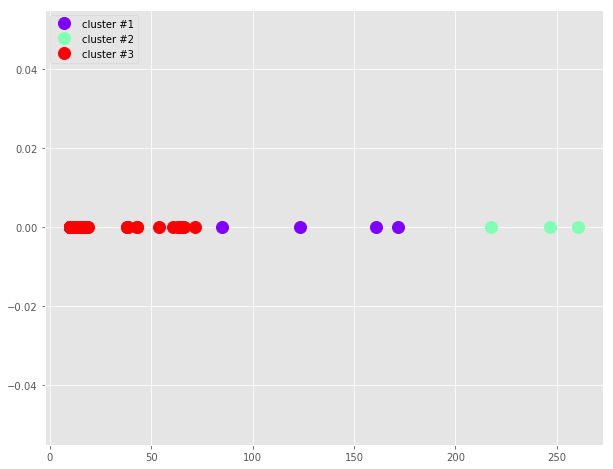

/Users/milicakojicic/anaconda/lib/python3.6/site-packages/bokeh/models/sources.py:81: BokehUserWarning: ColumnDataSource's columns must be of the same length
  lambda: warnings.warn("ColumnDataSource's columns must be of the same length", BokehUserWarning))
/Users/milicakojicic/anaconda/lib/python3.6/site-packages/bokeh/models/sources.py:81: BokehUserWarning: ColumnDataSource's columns must be of the same length
  lambda: warnings.warn("ColumnDataSource's columns must be of the same length", BokehUserWarning))
/Users/milicakojicic/anaconda/lib/python3.6/site-packages/bokeh/models/sources.py:81: BokehUserWarning: ColumnDataSource's columns must be of the same length
  lambda: warnings.warn("ColumnDataSource's columns must be of the same length", BokehUserWarning))
/Users/milicakojicic/anaconda/lib/python3.6/site-packages/bokeh/models/sources.py:81: BokehUserWarning: ColumnDataSource's columns must be of the same length
  lambda: warnings.warn("ColumnDataSource's columns must be of the s

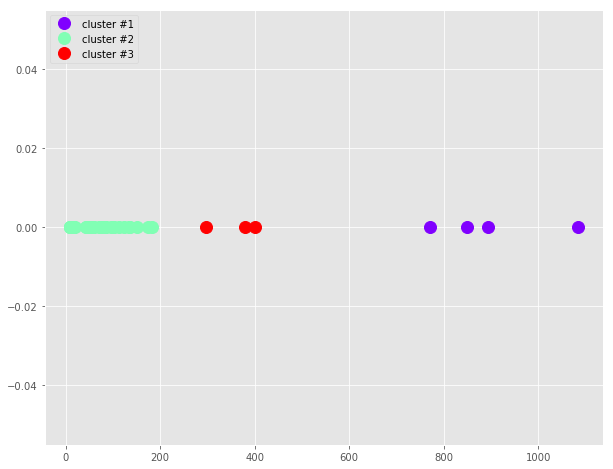

In [296]:
##############VIZUALIZACIJA I TUMORA I NORMALA################

visualize(num_of_clusters, new_dataframe_tumor, 1)
visualize(num_of_clusters, new_dataframe_normal, 1)

########NECEMO DA NAM SE PRIKAZUJU CRVENI WARNING#########
from IPython.display import HTML
HTML('''<script>
code_show_err=false; 
function code_toggle_err() {
 if (code_show_err){
 $('div.output_stderr').hide();
 } else {
 $('div.output_stderr').show();
 }
 code_show_err = !code_show_err
} 
$( document ).ready(code_toggle_err);
</script>
To toggle on/off output_stderr, click <a href="javascript:code_toggle_err()">here</a>.''')

In [297]:
##################IZVOZ PODATAKA U .CSV FORMAT########

del new_dataframe_tumor['y']
del new_dataframe_normal['y']

for i in reversed(range(0, num_of_clusters)):
    new_dataframe_tumor.loc[new_dataframe_tumor['cluster'] == i, 'cluster'] = i+1
new_dataframe_tumor.to_csv('tumor_gene_expression.csv', index = False)

for i in reversed(range(0, num_of_clusters)):
    new_dataframe_normal.loc[new_dataframe_normal['cluster'] == i, 'cluster'] = i+1
new_dataframe_normal.to_csv('normal_gene_expression.csv', index = False)